In [1]:
import sqlite3
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt

from sqlite3 import Error
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import math



kaggle_data = sqlite3.connect('D:/database/database.sqlite')

In [2]:
# Reading the Kaggle dataset

Country = pd.read_sql_query("SELECT * FROM Country", kaggle_data)
Match_raw = pd.read_sql_query("SELECT * FROM Match", kaggle_data)
Player_Attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", kaggle_data)

In [3]:
# Dropping unnecessary columns in the match dataset

betting_odds_indices = np.arange(Match_raw.columns.get_loc('BWH'),Match_raw.columns.get_loc('BSA')+1,1)
Match_raw = Match_raw.drop(Match_raw.columns[betting_odds_indices], axis=1)
X_Y_player_indices = np.arange(Match_raw.columns.get_loc("home_player_X1"),Match_raw.columns.get_loc("away_player_Y11")+1,1)
Match = Match_raw.drop(Match_raw.columns[X_Y_player_indices], axis=1) 
Match = Match.drop(['id','league_id','stage','shoton','shotoff','foulcommit','card','cross','corner','possession','goal'], axis=1) 
Match = Match.dropna(subset= ['B365H','B365D','B365A'])

# Dropping matches from smaller leagues (none - big 5 leagues)
Match = Match.drop(Match[Match['country_id']==1].index)
Match = Match.drop(Match[Match['country_id']==13274].index)
Match = Match.drop(Match[Match['country_id']==15722].index)
Match = Match.drop(Match[Match['country_id']==17642].index)
Match = Match.drop(Match[Match['country_id']==19694].index)
Match = Match.drop(Match[Match['country_id']==24558].index)

In [4]:
# Reading the match-level elo dataset and merging

filepath = 'D:/database/Elos.csv'
elos = pd.read_csv(filepath)
elos_keep=elos[['match_api_id','Home_Elo','Away_Elo']]

In [5]:
Match  = Match.merge(elos_keep, how = 'left',left_on='match_api_id',right_on = 'match_api_id')

In [6]:
# Creating year and half variables, player attributes will be merged to matches based on year-half

Match['year'] = pd.to_datetime(Match['date']).dt.year
Match['month'] = pd.to_datetime(Match['date']).dt.month
Player_Attributes['year'] = pd.to_datetime(Player_Attributes['date']).dt.year
Player_Attributes['month'] = pd.to_datetime(Player_Attributes['date']).dt.month
Match['half'] = np.where(Match['month'] <7 , 1, 2)
Player_Attributes['half'] = np.where(Player_Attributes['month'] <7 , 1, 2)

# Sorting all datasets based on dates
Match = Match.sort_values(by='date',ascending = True)
Player_Attributes = Player_Attributes.sort_values(by='date',ascending = True)

In [7]:
# Creating labels for match results
# 1 is home team win, -1 is home team loss, 0 is draw

Match['Result'] = Match['home_team_goal'] - Match['away_team_goal']
Match['Result'].loc[Match.Result > 0 ] = 1
Match['Result'].loc[Match.Result < 0] = -1

In [8]:
#Team form feature creation
#Match Form is based on previous 5 home/away match results

def Home_Team_Match_Form (df):
        
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['Result'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

def Away_Team_Match_Form (df):
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['Result'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

In [9]:
Match['Home_Team_Match_Form'] = Match.apply(lambda x: Home_Team_Match_Form(x),axis=1 )
Match['Away_Team_Match_Form'] = Match.apply(lambda x: Away_Team_Match_Form(x),axis=1 )

In [10]:
#Team Offensive form feature creation
#Attacking Form is based on goals scored in previous 5 home/away matches

def Home_Team_Offensive_Form (df):
        
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['home_team_goal'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

def Away_Team_Offensive_Form (df):
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['away_team_goal'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

In [11]:
Match['Home_Team_Offensive_Form'] = Match.apply(lambda x: Home_Team_Offensive_Form(x),axis=1 )
Match['Away_Team_Offensive_Form'] = Match.apply(lambda x: Away_Team_Offensive_Form(x),axis=1 )

In [12]:
#Team Defensive form feature creation
#Defensive Form is based on goals conceded in previous 5 home/away matches

def Home_Team_Defensive_Form (df):
        
    team = df['home_team_api_id']
    date = df['date']
    team_matches = Match[(Match['home_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['away_team_goal'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

def Away_Team_Defensive_Form (df):
    
    team = df['away_team_api_id']
    date = df['date']
    team_matches = Match[(Match['away_team_api_id'] == team)]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:5,:]
    if last_matches['match_api_id'].count()>=5:
        score = last_matches['home_team_goal'].sum()
    elif last_matches['match_api_id'].count()<5:
        score = -100
    return score

In [13]:
Match['Home_Team_Defensive_Form'] = Match.apply(lambda x: Home_Team_Defensive_Form(x),axis=1 )
Match['Away_Team_Defensive_Form'] = Match.apply(lambda x: Away_Team_Defensive_Form(x),axis=1 )

In [14]:
#Dropping matches with insufficient features
Match = Match[ (Match['Home_Team_Match_Form'] != -100) & (Match['Home_Team_Offensive_Form'] != -100) & (Match['Home_Team_Defensive_Form'] != -100) & (Match['Away_Team_Match_Form'] != -100) & (Match['Away_Team_Offensive_Form'] != -100) & (Match['Away_Team_Offensive_Form'] != -100)]

In [15]:
# Dropping matches that do not have player data
Match2 = Match.dropna(subset= ['home_player_1','home_player_2','home_player_3','home_player_4','home_player_5',\
                           'home_player_6','home_player_7','home_player_8','home_player_9','home_player_10',\
                           'home_player_11','away_player_1','away_player_2','away_player_3','away_player_4',
                           'away_player_5','away_player_6','away_player_7','away_player_8','away_player_9',
                           'away_player_10','away_player_11'])

In [16]:
# Deleting datapoints that lack identifying information, duplicates, and unnecessary columns in the player attributes dataset

Player_Attributes = Player_Attributes.dropna(subset= ['player_api_id','year','half'])
Player_Attributes = Player_Attributes.drop_duplicates(subset=['player_api_id','year','half'])
Player_Attributes = Player_Attributes.drop(['id','player_fifa_api_id','potential','preferred_foot','attacking_work_rate','defensive_work_rate','month','date'],axis=1)

In [17]:
player_h1 = Player_Attributes.copy()
player_h1.columns = ['player_api_id','overall_rating_h1','crossing_h1','finishing_h1','heading_accuracy_h1','short_passing_h1','volleys_h1','dribbling_h1','curve_h1','free_kick_accuracy_h1','long_passing_h1','ball_control_h1','acceleration_h1','sprint_speed_h1','agility_h1','reactions_h1','balance_h1','shot_power_h1','jumping_h1','stamina_h1','strength_h1','long_shots_h1','aggression_h1','interceptions_h1','positioning_h1','vision_h1','penalties_h1','marking_h1','standing_tackle_h1','sliding_tackle_h1','gk_diving_h1','gk_handling_h1','gk_kicking_h1','gk_positioning_h1','gk_reflexes_h1','year','half']
player_h1.to_csv('D:/database/player_h1.csv')
# Match2  = Match2.merge(player_h1, how = 'left',left_on=['home_player_1','year','half'],right_on = ['player_api_id','year','half'])

In [18]:
player_a1 = Player_Attributes.copy()
player_a1.columns = ['player_api_id','overall_rating_a1','crossing_a1','finishing_a1','heading_accuracy_a1','short_passing_a1','volleys_a1','dribbling_a1','curve_a1','free_kick_accuracy_a1','long_passing_a1','ball_control_a1','acceleration_a1','sprint_speed_a1','agility_a1','reactions_a1','balance_a1','shot_power_a1','jumping_a1','stamina_a1','strength_a1','long_shots_a1','aggression_a1','interceptions_a1','positioning_a1','vision_a1','penalties_a1','marking_a1','standing_tackle_a1','sliding_tackle_a1','gk_diving_a1','gk_handling_a1','gk_kicking_a1','gk_positioning_a1','gk_reflexes_a1','year','half']
player_a1.to_csv('D:/database/player_a1.csv')
# Match2  = Match2.merge(player_a1, how = 'left',left_on=['away_player_1','year','half'],right_on = ['player_api_id','year','half'])

In [19]:
Match2.to_csv('D:/database/match.csv')

In [20]:
# Ran into an error when trying to merge on Python, so used another language (SAS) to merge the data
# The SAS code is uploaded on github
# Home wins have been relabelled as 2, draws as 1, and home losses as 0
# Averaged player attributes for each team (34 attributes per player, 11 players per team, 2 teams per match)
# 12,633 datapoints in total, each datapoint has 11 team level features, 68 player-level features (34 for each team)

In [21]:
match = pd.read_csv('D:/database/merged.csv')

In [22]:
train = match[(match['season']=='2008/2009') | (match['season']=='2009/2010') | (match['season']=='2010/2011') | (match['season']=='2011/2012') | (match['season']=='2012/2013') | (match['season']=='2013/2014')]

dev = match[(match['season']=='2014/2015')]

test = match[(match['season']=='2015/2016')]

In [23]:
train = train.drop(['season'], axis=1)
dev = dev.drop(['season'], axis=1)
test = test.drop(['season'], axis=1)

In [24]:
train_features = train.drop(['result'],axis=1)
train_labels = train[['match_api_id','result']]
dev_features = dev.drop(['result'],axis=1)
dev_labels = dev[['match_api_id','result']]
test_features = test.drop(['result'],axis=1)
test_labels = test[['match_api_id','result']]

In [25]:
## save pre-processed data

train_features.to_csv('D:/database/data/train_features.csv')
train_labels.to_csv('D:/database/data/train_labels.csv')
dev_features.to_csv('D:/database/data/dev_features.csv')
dev_labels.to_csv('D:/database/data/dev_labels.csv')
test_features.to_csv('D:/database/data/test_features.csv')
test_labels.to_csv('D:/database/data/test_labels.csv')
match.to_csv('D:/database/data/combined.csv')

In [26]:
## read saved data

X_train = pd.read_csv('D:/database/data/train_features.csv')
y_train = pd.read_csv('D:/database/data/train_labels.csv')
X_dev = pd.read_csv('D:/database/data/dev_features.csv')
y_dev = pd.read_csv('D:/database/data/dev_labels.csv')
X_test = pd.read_csv('D:/database/data/test_features.csv')
y_test = pd.read_csv('D:/database/data/test_labels.csv')

In [27]:
## take inverse of odds

X_train['H_odds']=1/X_train['B365H']
X_train['D_odds']=1/X_train['B365D']
X_train['A_odds']=1/X_train['B365A']

X_test['H_odds']=1/X_test['B365H']
X_test['D_odds']=1/X_test['B365D']
X_test['A_odds']=1/X_test['B365A']

X_dev['H_odds']=1/X_dev['B365H']
X_dev['D_odds']=1/X_dev['B365D']
X_dev['A_odds']=1/X_dev['B365A']

In [28]:
## drop unnecessary features

X_train = X_train.drop(['Unnamed: 0','match_api_id','B365H','B365D','B365A'],axis=1)
y_train = y_train.drop(['Unnamed: 0','match_api_id'],axis=1)
X_dev = X_dev.drop(['Unnamed: 0','match_api_id','B365H','B365D','B365A'],axis=1)
y_dev = y_dev.drop(['Unnamed: 0','match_api_id'],axis=1)
X_test = X_test.drop(['Unnamed: 0','match_api_id','B365H','B365D','B365A'],axis=1)
y_test = y_test.drop(['Unnamed: 0','match_api_id'],axis=1)

In [29]:
## convert to numpy arrays

X_train=X_train.to_numpy()
X_dev=X_dev.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_dev=y_dev.to_numpy()
y_test=y_test.to_numpy()

In [30]:
## define function to turn labels into one-hot vectors

def one_hot(y, c):
    
    y = np.transpose(y)
    y_hot = np.zeros((y.size, y.max()+1), dtype=int)
    y_hot[np.arange(y.size),y] = 1 
    return y_hot

In [31]:
## create one-hot vectors

Y_train=one_hot(y_train,3)
Y_test=one_hot(y_test,3)
Y_dev=one_hot(y_dev,3)

In [32]:
## build main model, 5 hidden layers with 64 neurons each, leaky relu activation, dropout used for regularization

def train_model(features, labels, learning_rate, alpha_leakyrelu, dropout, bsize, numepochs):

    
    model = Sequential()
    model.add(Dense(64,input_dim=features.shape[1], kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=alpha_leakyrelu))
    model.add(Dropout(dropout))
    model.add(Dense(64,kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=alpha_leakyrelu))
    model.add(Dropout(dropout))
    model.add(Dense(64,kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=alpha_leakyrelu))
    model.add(Dropout(dropout))
    model.add(Dense(64,kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=alpha_leakyrelu))
    model.add(Dropout(dropout))
    model.add(Dense(64,kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=alpha_leakyrelu))
    model.add(Dense(labels.shape[1], kernel_initializer='normal', activation='softmax'))
    opt = Adam(lr=learning_rate)
    
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()
    
    
    
    csv_logger = CSVLogger('log.csv', append=True, separator=';')
    trained = model.fit(features,labels,epochs=numepochs,batch_size=bsize, callbacks=[csv_logger])
    loss_history =  trained.history["loss"]
    accuracy_history =  trained.history["accuracy"]
    
    return model, loss_history, accuracy_history

In [33]:
## train main model

model, loss_history, accuracy_history = train_model(X_train, Y_train, 0.000001, 0.1, 0.20, 256, 10000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5120      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4

37/37 [==============================] - 0s 6ms/step - loss: 1.0843 - accuracy: 0.4393
Epoch 58/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0823 - accuracy: 0.4421
Epoch 59/10000
37/37 [==============================] - 0s 7ms/step - loss: 1.0798 - accuracy: 0.4441
Epoch 60/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0840 - accuracy: 0.4438
Epoch 61/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0770 - accuracy: 0.4441
Epoch 62/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0837 - accuracy: 0.4406
Epoch 63/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0875 - accuracy: 0.4378
Epoch 64/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0812 - accuracy: 0.4460
Epoch 65/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0802 - accuracy: 0.4500
Epoch 66/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0815 - accuracy: 0.

37/37 [==============================] - 0s 6ms/step - loss: 1.0738 - accuracy: 0.4515
Epoch 138/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0724 - accuracy: 0.4601
Epoch 139/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0731 - accuracy: 0.4581
Epoch 140/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0720 - accuracy: 0.4596
Epoch 141/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0745 - accuracy: 0.4544
Epoch 142/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0715 - accuracy: 0.4550
Epoch 143/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0728 - accuracy: 0.4567
Epoch 144/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0714 - accuracy: 0.4610
Epoch 145/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0718 - accuracy: 0.4611
Epoch 146/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0743 - acc

37/37 [==============================] - 0s 6ms/step - loss: 1.0671 - accuracy: 0.4627
Epoch 217/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0661 - accuracy: 0.4646
Epoch 218/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0680 - accuracy: 0.4636
Epoch 219/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0661 - accuracy: 0.4640
Epoch 220/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0671 - accuracy: 0.4632
Epoch 221/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0660 - accuracy: 0.4639
Epoch 222/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0674 - accuracy: 0.4626
Epoch 223/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0680 - accuracy: 0.4650
Epoch 224/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0667 - accuracy: 0.4641
Epoch 225/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0651 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0647 - accuracy: 0.4642
Epoch 296/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0645 - accuracy: 0.4676
Epoch 297/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0625 - accuracy: 0.4668
Epoch 298/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0634 - accuracy: 0.4658
Epoch 299/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0639 - accuracy: 0.4653
Epoch 300/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0629 - accuracy: 0.4660
Epoch 301/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0633 - accuracy: 0.4670
Epoch 302/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0651 - accuracy: 0.4654
Epoch 303/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0644 - accuracy: 0.4663
Epoch 304/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0625 - acc

37/37 [==============================] - 0s 6ms/step - loss: 1.0603 - accuracy: 0.4666
Epoch 375/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0618 - accuracy: 0.4668
Epoch 376/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0610 - accuracy: 0.4671
Epoch 377/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0616 - accuracy: 0.4668
Epoch 378/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0622 - accuracy: 0.4670
Epoch 379/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0607 - accuracy: 0.4669
Epoch 380/10000
37/37 [==============================] - 0s 7ms/step - loss: 1.0628 - accuracy: 0.4671
Epoch 381/10000
37/37 [==============================] - 1s 15ms/step - loss: 1.0611 - accuracy: 0.4673
Epoch 382/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0618 - accuracy: 0.4664
Epoch 383/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0622 - ac

37/37 [==============================] - 0s 4ms/step - loss: 1.0597 - accuracy: 0.4668
Epoch 454/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0601 - accuracy: 0.4668
Epoch 455/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0611 - accuracy: 0.4674
Epoch 456/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0593 - accuracy: 0.4668
Epoch 457/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0576 - accuracy: 0.4678
Epoch 458/10000
37/37 [==============================] - 0s 6ms/step - loss: 1.0610 - accuracy: 0.4672
Epoch 459/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0590 - accuracy: 0.4672
Epoch 460/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0595 - accuracy: 0.4675
Epoch 461/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0601 - accuracy: 0.4669
Epoch 462/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0589 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0579 - accuracy: 0.4674
Epoch 533/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0557 - accuracy: 0.4675
Epoch 534/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0580 - accuracy: 0.4672
Epoch 535/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.4669
Epoch 536/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0577 - accuracy: 0.4673
Epoch 537/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0562 - accuracy: 0.4672
Epoch 538/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0570 - accuracy: 0.4675
Epoch 539/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0565 - accuracy: 0.4671
Epoch 540/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.4669
Epoch 541/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0546 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0563 - accuracy: 0.4675
Epoch 612/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0557 - accuracy: 0.4675
Epoch 613/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0534 - accuracy: 0.4672
Epoch 614/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0553 - accuracy: 0.4679
Epoch 615/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0561 - accuracy: 0.4676
Epoch 616/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0535 - accuracy: 0.4669
Epoch 617/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0541 - accuracy: 0.4681
Epoch 618/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0529 - accuracy: 0.4678
Epoch 619/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0558 - accuracy: 0.4676
Epoch 620/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0553 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0532 - accuracy: 0.4671
Epoch 691/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0520 - accuracy: 0.4674
Epoch 692/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0532 - accuracy: 0.4675
Epoch 693/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0523 - accuracy: 0.4673
Epoch 694/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0518 - accuracy: 0.4682
Epoch 695/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0520 - accuracy: 0.4674
Epoch 696/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0538 - accuracy: 0.4671
Epoch 697/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0537 - accuracy: 0.4676
Epoch 698/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0527 - accuracy: 0.4673
Epoch 699/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0519 - acc

37/37 [==============================] - 0s 4ms/step - loss: 1.0502 - accuracy: 0.4676
Epoch 770/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0501 - accuracy: 0.4682
Epoch 771/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0525 - accuracy: 0.4675
Epoch 772/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0495 - accuracy: 0.4687
Epoch 773/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0520 - accuracy: 0.4681
Epoch 774/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0510 - accuracy: 0.4670
Epoch 775/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0504 - accuracy: 0.4676
Epoch 776/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0507 - accuracy: 0.4676
Epoch 777/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0513 - accuracy: 0.4672
Epoch 778/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0513 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0475 - accuracy: 0.4695
Epoch 849/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0488 - accuracy: 0.4701
Epoch 850/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0477 - accuracy: 0.4683
Epoch 851/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0476 - accuracy: 0.4689
Epoch 852/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0492 - accuracy: 0.4676
Epoch 853/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0489 - accuracy: 0.4690
Epoch 854/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0478 - accuracy: 0.4692
Epoch 855/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0484 - accuracy: 0.4681
Epoch 856/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0475 - accuracy: 0.4676
Epoch 857/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0459 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0436 - accuracy: 0.4687
Epoch 928/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0428 - accuracy: 0.4712
Epoch 929/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0446 - accuracy: 0.4678
Epoch 930/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0453 - accuracy: 0.4681
Epoch 931/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0456 - accuracy: 0.4693
Epoch 932/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0438 - accuracy: 0.4695
Epoch 933/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0429 - accuracy: 0.4718
Epoch 934/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0450 - accuracy: 0.4692
Epoch 935/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0442 - accuracy: 0.4678
Epoch 936/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0444 - acc

37/37 [==============================] - 0s 5ms/step - loss: 1.0399 - accuracy: 0.4716
Epoch 1007/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0405 - accuracy: 0.4700
Epoch 1008/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0405 - accuracy: 0.4728
Epoch 1009/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0405 - accuracy: 0.4709
Epoch 1010/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0399 - accuracy: 0.4724
Epoch 1011/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0400 - accuracy: 0.4735
Epoch 1012/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0412 - accuracy: 0.4761
Epoch 1013/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0420 - accuracy: 0.4733
Epoch 1014/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0404 - accuracy: 0.4693
Epoch 1015/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0374 - accuracy: 0.4762
Epoch 1085/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0374 - accuracy: 0.4775
Epoch 1086/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0376 - accuracy: 0.4769
Epoch 1087/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0368 - accuracy: 0.4737
Epoch 1088/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0371 - accuracy: 0.4771
Epoch 1089/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0395 - accuracy: 0.4744
Epoch 1090/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0360 - accuracy: 0.4766
Epoch 1091/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0336 - accuracy: 0.4773
Epoch 1092/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0381 - accuracy: 0.4752
Epoch 1093/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0307 - accuracy: 0.4829
Epoch 1163/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0313 - accuracy: 0.4834
Epoch 1164/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0331 - accuracy: 0.4825
Epoch 1165/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0330 - accuracy: 0.4795
Epoch 1166/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0340 - accuracy: 0.4828
Epoch 1167/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0353 - accuracy: 0.4810
Epoch 1168/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0360 - accuracy: 0.4790
Epoch 1169/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0366 - accuracy: 0.4789
Epoch 1170/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0330 - accuracy: 0.4865
Epoch 1171/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0315 - accuracy: 0.4854
Epoch 1241/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0304 - accuracy: 0.4859
Epoch 1242/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0295 - accuracy: 0.4876
Epoch 1243/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0306 - accuracy: 0.4812
Epoch 1244/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0293 - accuracy: 0.4850
Epoch 1245/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0308 - accuracy: 0.4850
Epoch 1246/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0314 - accuracy: 0.4848
Epoch 1247/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0274 - accuracy: 0.4888
Epoch 1248/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0313 - accuracy: 0.4866
Epoch 1249/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0263 - accuracy: 0.4908
Epoch 1319/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0292 - accuracy: 0.4895
Epoch 1320/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0259 - accuracy: 0.4898
Epoch 1321/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0239 - accuracy: 0.4891
Epoch 1322/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0302 - accuracy: 0.4862
Epoch 1323/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0263 - accuracy: 0.4882
Epoch 1324/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0256 - accuracy: 0.4938
Epoch 1325/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0270 - accuracy: 0.4876
Epoch 1326/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0259 - accuracy: 0.4874
Epoch 1327/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0223 - accuracy: 0.4918
Epoch 1397/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0247 - accuracy: 0.4930
Epoch 1398/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0218 - accuracy: 0.4956
Epoch 1399/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0235 - accuracy: 0.4914
Epoch 1400/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0241 - accuracy: 0.4933
Epoch 1401/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0228 - accuracy: 0.4905
Epoch 1402/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0257 - accuracy: 0.4867
Epoch 1403/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0243 - accuracy: 0.4895
Epoch 1404/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0247 - accuracy: 0.4949
Epoch 1405/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 4ms/step - loss: 1.0236 - accuracy: 0.4905
Epoch 1475/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0211 - accuracy: 0.4929
Epoch 1476/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0205 - accuracy: 0.4927
Epoch 1477/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0228 - accuracy: 0.4941
Epoch 1478/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0237 - accuracy: 0.4904
Epoch 1479/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0189 - accuracy: 0.4966
Epoch 1480/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0219 - accuracy: 0.4981
Epoch 1481/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0193 - accuracy: 0.4914
Epoch 1482/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0211 - accuracy: 0.4951
Epoch 1483/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0166 - accuracy: 0.4963
Epoch 1553/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0188 - accuracy: 0.4943
Epoch 1554/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0196 - accuracy: 0.4991
Epoch 1555/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0187 - accuracy: 0.4961
Epoch 1556/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0197 - accuracy: 0.4951
Epoch 1557/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0166 - accuracy: 0.4980
Epoch 1558/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0201 - accuracy: 0.4981
Epoch 1559/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0202 - accuracy: 0.4972
Epoch 1560/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0148 - accuracy: 0.5027
Epoch 1561/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0165 - accuracy: 0.4997
Epoch 1631/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0165 - accuracy: 0.5047
Epoch 1632/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0153 - accuracy: 0.4989
Epoch 1633/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0143 - accuracy: 0.5009
Epoch 1634/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0196 - accuracy: 0.5013
Epoch 1635/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0192 - accuracy: 0.4960
Epoch 1636/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0192 - accuracy: 0.5005
Epoch 1637/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0184 - accuracy: 0.5005
Epoch 1638/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0168 - accuracy: 0.5016
Epoch 1639/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0168 - accuracy: 0.4977
Epoch 1709/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0138 - accuracy: 0.5038
Epoch 1710/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0125 - accuracy: 0.4983
Epoch 1711/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0146 - accuracy: 0.5029
Epoch 1712/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0133 - accuracy: 0.5057
Epoch 1713/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0155 - accuracy: 0.4965
Epoch 1714/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0164 - accuracy: 0.5020
Epoch 1715/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0135 - accuracy: 0.5014
Epoch 1716/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0147 - accuracy: 0.5027
Epoch 1717/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 4ms/step - loss: 1.0143 - accuracy: 0.5005
Epoch 1787/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0151 - accuracy: 0.4989
Epoch 1788/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0147 - accuracy: 0.5011
Epoch 1789/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0141 - accuracy: 0.5030
Epoch 1790/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0126 - accuracy: 0.4997
Epoch 1791/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0131 - accuracy: 0.5061
Epoch 1792/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0118 - accuracy: 0.5055
Epoch 1793/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0102 - accuracy: 0.5059
Epoch 1794/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0134 - accuracy: 0.5014
Epoch 1795/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0130 - accuracy: 0.5026
Epoch 1865/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0109 - accuracy: 0.5086
Epoch 1866/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0120 - accuracy: 0.5000
Epoch 1867/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0092 - accuracy: 0.5035
Epoch 1868/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0121 - accuracy: 0.5041
Epoch 1869/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0115 - accuracy: 0.5042
Epoch 1870/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0103 - accuracy: 0.5063
Epoch 1871/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0106 - accuracy: 0.5076
Epoch 1872/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0105 - accuracy: 0.5031
Epoch 1873/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0100 - accuracy: 0.5092
Epoch 1943/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0095 - accuracy: 0.5078
Epoch 1944/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0097 - accuracy: 0.5042
Epoch 1945/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0102 - accuracy: 0.5045
Epoch 1946/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0118 - accuracy: 0.5070
Epoch 1947/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0119 - accuracy: 0.5049
Epoch 1948/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0103 - accuracy: 0.5043
Epoch 1949/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0118 - accuracy: 0.5054
Epoch 1950/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0088 - accuracy: 0.5068
Epoch 1951/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0079 - accuracy: 0.5068
Epoch 2021/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0115 - accuracy: 0.5053
Epoch 2022/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0080 - accuracy: 0.5059
Epoch 2023/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0049 - accuracy: 0.5082
Epoch 2024/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0086 - accuracy: 0.5089
Epoch 2025/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0100 - accuracy: 0.5057
Epoch 2026/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0079 - accuracy: 0.5066
Epoch 2027/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0074 - accuracy: 0.5067
Epoch 2028/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0091 - accuracy: 0.5029
Epoch 2029/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0108 - accuracy: 0.5076
Epoch 2099/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0085 - accuracy: 0.5058
Epoch 2100/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0081 - accuracy: 0.5102
Epoch 2101/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0066 - accuracy: 0.5123
Epoch 2102/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0084 - accuracy: 0.5088
Epoch 2103/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0047 - accuracy: 0.5102
Epoch 2104/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0085 - accuracy: 0.5084
Epoch 2105/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0093 - accuracy: 0.5099
Epoch 2106/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0073 - accuracy: 0.5051
Epoch 2107/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0069 - accuracy: 0.5092
Epoch 2177/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0051 - accuracy: 0.5066
Epoch 2178/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0043 - accuracy: 0.5141
Epoch 2179/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0053 - accuracy: 0.5103
Epoch 2180/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0065 - accuracy: 0.5081
Epoch 2181/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0079 - accuracy: 0.5080
Epoch 2182/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0084 - accuracy: 0.5041
Epoch 2183/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0047 - accuracy: 0.5081
Epoch 2184/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0074 - accuracy: 0.5074
Epoch 2185/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0102 - accuracy: 0.5078
Epoch 2255/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0049 - accuracy: 0.5110
Epoch 2256/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0047 - accuracy: 0.5068
Epoch 2257/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0041 - accuracy: 0.5078
Epoch 2258/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0057 - accuracy: 0.5088
Epoch 2259/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0048 - accuracy: 0.5092
Epoch 2260/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0037 - accuracy: 0.5119
Epoch 2261/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0015 - accuracy: 0.5143
Epoch 2262/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0060 - accuracy: 0.5072
Epoch 2263/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0036 - accuracy: 0.5143
Epoch 2333/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0064 - accuracy: 0.5099
Epoch 2334/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0052 - accuracy: 0.5097
Epoch 2335/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0044 - accuracy: 0.5101
Epoch 2336/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0032 - accuracy: 0.5141
Epoch 2337/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0084 - accuracy: 0.5103
Epoch 2338/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0066 - accuracy: 0.5113
Epoch 2339/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0024 - accuracy: 0.5137
Epoch 2340/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0049 - accuracy: 0.5123
Epoch 2341/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0054 - accuracy: 0.5105
Epoch 2411/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0047 - accuracy: 0.5114
Epoch 2412/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0074 - accuracy: 0.5112
Epoch 2413/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0036 - accuracy: 0.5083
Epoch 2414/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0016 - accuracy: 0.5137
Epoch 2415/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0033 - accuracy: 0.5142
Epoch 2416/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0027 - accuracy: 0.5111
Epoch 2417/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0035 - accuracy: 0.5126
Epoch 2418/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0018 - accuracy: 0.5121
Epoch 2419/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0038 - accuracy: 0.5135
Epoch 2489/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0034 - accuracy: 0.5064
Epoch 2490/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0036 - accuracy: 0.5094
Epoch 2491/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0039 - accuracy: 0.5141
Epoch 2492/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0048 - accuracy: 0.5106
Epoch 2493/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0023 - accuracy: 0.5077
Epoch 2494/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0028 - accuracy: 0.5127
Epoch 2495/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0051 - accuracy: 0.5092
Epoch 2496/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0032 - accuracy: 0.5117
Epoch 2497/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0034 - accuracy: 0.5137
Epoch 2567/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0042 - accuracy: 0.5137
Epoch 2568/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0044 - accuracy: 0.5098
Epoch 2569/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0030 - accuracy: 0.5107
Epoch 2570/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0023 - accuracy: 0.5147
Epoch 2571/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0027 - accuracy: 0.5146
Epoch 2572/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0045 - accuracy: 0.5155
Epoch 2573/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0027 - accuracy: 0.5131
Epoch 2574/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0036 - accuracy: 0.5119
Epoch 2575/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.5170
Epoch 2645/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0035 - accuracy: 0.5105
Epoch 2646/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0018 - accuracy: 0.5083
Epoch 2647/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0015 - accuracy: 0.5149
Epoch 2648/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0021 - accuracy: 0.5127
Epoch 2649/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0022 - accuracy: 0.5157
Epoch 2650/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0052 - accuracy: 0.5089
Epoch 2651/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0003 - accuracy: 0.5120
Epoch 2652/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0015 - accuracy: 0.5153
Epoch 2653/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.5155
Epoch 2723/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0023 - accuracy: 0.5109
Epoch 2724/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0025 - accuracy: 0.5124
Epoch 2725/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0041 - accuracy: 0.5118
Epoch 2726/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0032 - accuracy: 0.5149
Epoch 2727/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0026 - accuracy: 0.5111
Epoch 2728/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0017 - accuracy: 0.5113
Epoch 2729/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.5133
Epoch 2730/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0034 - accuracy: 0.5129
Epoch 2731/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0009 - accuracy: 0.5137
Epoch 2801/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0012 - accuracy: 0.5177
Epoch 2802/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9985 - accuracy: 0.5154
Epoch 2803/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0014 - accuracy: 0.5130
Epoch 2804/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0032 - accuracy: 0.5147
Epoch 2805/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0011 - accuracy: 0.5126
Epoch 2806/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0022 - accuracy: 0.5113
Epoch 2807/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0026 - accuracy: 0.5092
Epoch 2808/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0021 - accuracy: 0.5138
Epoch 2809/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0007 - accuracy: 0.5178
Epoch 2879/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0008 - accuracy: 0.5115
Epoch 2880/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0015 - accuracy: 0.5142
Epoch 2881/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9988 - accuracy: 0.5176
Epoch 2882/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9998 - accuracy: 0.5141
Epoch 2883/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0023 - accuracy: 0.5160
Epoch 2884/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0039 - accuracy: 0.5140
Epoch 2885/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0011 - accuracy: 0.5132
Epoch 2886/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0003 - accuracy: 0.5150
Epoch 2887/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 1.0006 - accuracy: 0.5160
Epoch 2957/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0018 - accuracy: 0.5153
Epoch 2958/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9987 - accuracy: 0.5195
Epoch 2959/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0019 - accuracy: 0.5160
Epoch 2960/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0021 - accuracy: 0.5140
Epoch 2961/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0015 - accuracy: 0.5154
Epoch 2962/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0009 - accuracy: 0.5119
Epoch 2963/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0010 - accuracy: 0.5098
Epoch 2964/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9991 - accuracy: 0.5150
Epoch 2965/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 0.9993 - accuracy: 0.5178
Epoch 3035/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0002 - accuracy: 0.5142
Epoch 3036/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0010 - accuracy: 0.5132
Epoch 3037/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0002 - accuracy: 0.5141
Epoch 3038/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0013 - accuracy: 0.5105
Epoch 3039/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0021 - accuracy: 0.5152
Epoch 3040/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9997 - accuracy: 0.5148
Epoch 3041/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0019 - accuracy: 0.5164
Epoch 3042/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0012 - accuracy: 0.5150
Epoch 3043/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 0.9984 - accuracy: 0.5186
Epoch 3113/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0011 - accuracy: 0.5154
Epoch 3114/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0013 - accuracy: 0.5132
Epoch 3115/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.5152
Epoch 3116/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9995 - accuracy: 0.5128
Epoch 3117/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5147
Epoch 3118/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9988 - accuracy: 0.5163
Epoch 3119/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5152
Epoch 3120/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.5153
Epoch 3121/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 1.0001 - accuracy: 0.5141
Epoch 3191/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0008 - accuracy: 0.5137
Epoch 3192/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9988 - accuracy: 0.5161
Epoch 3193/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0007 - accuracy: 0.5182
Epoch 3194/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0017 - accuracy: 0.5104
Epoch 3195/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0000 - accuracy: 0.5162
Epoch 3196/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0015 - accuracy: 0.5157
Epoch 3197/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5168
Epoch 3198/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5140
Epoch 3199/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5176
Epoch 3269/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0006 - accuracy: 0.5138
Epoch 3270/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9988 - accuracy: 0.5181
Epoch 3271/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9978 - accuracy: 0.5169
Epoch 3272/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9997 - accuracy: 0.5162
Epoch 3273/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9990 - accuracy: 0.5146
Epoch 3274/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9989 - accuracy: 0.5159
Epoch 3275/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9997 - accuracy: 0.5121
Epoch 3276/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.5156
Epoch 3277/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9996 - accuracy: 0.5156
Epoch 3347/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.5138
Epoch 3348/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0008 - accuracy: 0.5162
Epoch 3349/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0007 - accuracy: 0.5152
Epoch 3350/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0016 - accuracy: 0.5158
Epoch 3351/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9994 - accuracy: 0.5141
Epoch 3352/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0014 - accuracy: 0.5145
Epoch 3353/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9995 - accuracy: 0.5174
Epoch 3354/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9989 - accuracy: 0.5150
Epoch 3355/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9996 - accuracy: 0.5186
Epoch 3425/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9993 - accuracy: 0.5150
Epoch 3426/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9999 - accuracy: 0.5186
Epoch 3427/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9998 - accuracy: 0.5162
Epoch 3428/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9978 - accuracy: 0.5184
Epoch 3429/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9998 - accuracy: 0.5143
Epoch 3430/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0006 - accuracy: 0.5157
Epoch 3431/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.5159
Epoch 3432/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0007 - accuracy: 0.5164
Epoch 3433/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9981 - accuracy: 0.5162
Epoch 3503/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.5147
Epoch 3504/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9994 - accuracy: 0.5170
Epoch 3505/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5170
Epoch 3506/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9987 - accuracy: 0.5141
Epoch 3507/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9984 - accuracy: 0.5174
Epoch 3508/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9981 - accuracy: 0.5172
Epoch 3509/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9991 - accuracy: 0.5186
Epoch 3510/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9972 - accuracy: 0.5172
Epoch 3511/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9991 - accuracy: 0.5140
Epoch 3581/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.5168
Epoch 3582/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9994 - accuracy: 0.5150
Epoch 3583/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9983 - accuracy: 0.5125
Epoch 3584/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9966 - accuracy: 0.5171
Epoch 3585/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.5152
Epoch 3586/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9980 - accuracy: 0.5182
Epoch 3587/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9986 - accuracy: 0.5162
Epoch 3588/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9983 - accuracy: 0.5160
Epoch 3589/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.5163
Epoch 3659/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0007 - accuracy: 0.5149
Epoch 3660/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9982 - accuracy: 0.5160
Epoch 3661/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9999 - accuracy: 0.5156
Epoch 3662/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5153
Epoch 3663/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9993 - accuracy: 0.5159
Epoch 3664/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9976 - accuracy: 0.5163
Epoch 3665/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9991 - accuracy: 0.5155
Epoch 3666/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9984 - accuracy: 0.5156
Epoch 3667/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.5192
Epoch 3737/10000
37/37 [==============================] - 0s 4ms/step - loss: 1.0000 - accuracy: 0.5182
Epoch 3738/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9983 - accuracy: 0.5147
Epoch 3739/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9994 - accuracy: 0.5147
Epoch 3740/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9968 - accuracy: 0.5204
Epoch 3741/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.5155
Epoch 3742/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5185
Epoch 3743/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.5149
Epoch 3744/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9968 - accuracy: 0.5170
Epoch 3745/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5161
Epoch 3815/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9974 - accuracy: 0.5143
Epoch 3816/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9988 - accuracy: 0.5168
Epoch 3817/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9979 - accuracy: 0.5185
Epoch 3818/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5145
Epoch 3819/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9976 - accuracy: 0.5167
Epoch 3820/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9976 - accuracy: 0.5170
Epoch 3821/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5166
Epoch 3822/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9967 - accuracy: 0.5171
Epoch 3823/10000
37/37 [==============================] - 0s 5ms/step - loss: 1.0

37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5161
Epoch 3893/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9957 - accuracy: 0.5161
Epoch 3894/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5182
Epoch 3895/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9972 - accuracy: 0.5195
Epoch 3896/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5197
Epoch 3897/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5181
Epoch 3898/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5167
Epoch 3899/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9971 - accuracy: 0.5156
Epoch 3900/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9966 - accuracy: 0.5148
Epoch 3901/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9957 - accuracy: 0.5204
Epoch 3971/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9964 - accuracy: 0.5186
Epoch 3972/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9972 - accuracy: 0.5196
Epoch 3973/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9977 - accuracy: 0.5175
Epoch 3974/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9954 - accuracy: 0.5156
Epoch 3975/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9980 - accuracy: 0.5182
Epoch 3976/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9964 - accuracy: 0.5183
Epoch 3977/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9967 - accuracy: 0.5178
Epoch 3978/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5163
Epoch 3979/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9959 - accuracy: 0.5132
Epoch 4049/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9984 - accuracy: 0.5154
Epoch 4050/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5191
Epoch 4051/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9979 - accuracy: 0.5163
Epoch 4052/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9948 - accuracy: 0.5191
Epoch 4053/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5159
Epoch 4054/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9967 - accuracy: 0.5187
Epoch 4055/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5148
Epoch 4056/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5149
Epoch 4057/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9977 - accuracy: 0.5168
Epoch 4127/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9956 - accuracy: 0.5161
Epoch 4128/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5157
Epoch 4129/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9969 - accuracy: 0.5177
Epoch 4130/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9997 - accuracy: 0.5172
Epoch 4131/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9973 - accuracy: 0.5163
Epoch 4132/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9964 - accuracy: 0.5142
Epoch 4133/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.5177
Epoch 4134/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9968 - accuracy: 0.5190
Epoch 4135/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9982 - accuracy: 0.5173
Epoch 4205/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9980 - accuracy: 0.5150
Epoch 4206/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5209
Epoch 4207/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5171
Epoch 4208/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9956 - accuracy: 0.5167
Epoch 4209/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9948 - accuracy: 0.5192
Epoch 4210/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5176
Epoch 4211/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9968 - accuracy: 0.5181
Epoch 4212/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9947 - accuracy: 0.5167
Epoch 4213/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9951 - accuracy: 0.5182
Epoch 4283/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9969 - accuracy: 0.5188
Epoch 4284/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9948 - accuracy: 0.5157
Epoch 4285/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9966 - accuracy: 0.5153
Epoch 4286/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9947 - accuracy: 0.5205
Epoch 4287/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9967 - accuracy: 0.5199
Epoch 4288/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9976 - accuracy: 0.5161
Epoch 4289/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5178
Epoch 4290/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5158
Epoch 4291/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9954 - accuracy: 0.5177
Epoch 4361/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9975 - accuracy: 0.5167
Epoch 4362/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5221
Epoch 4363/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9968 - accuracy: 0.5200
Epoch 4364/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9962 - accuracy: 0.5183
Epoch 4365/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9969 - accuracy: 0.5176
Epoch 4366/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9969 - accuracy: 0.5202
Epoch 4367/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9964 - accuracy: 0.5172
Epoch 4368/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5152
Epoch 4369/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9962 - accuracy: 0.5197
Epoch 4439/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5197
Epoch 4440/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9953 - accuracy: 0.5182
Epoch 4441/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9959 - accuracy: 0.5173
Epoch 4442/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9946 - accuracy: 0.5206
Epoch 4443/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5153
Epoch 4444/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5170
Epoch 4445/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9951 - accuracy: 0.5160
Epoch 4446/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5191
Epoch 4447/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5188
Epoch 4517/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9974 - accuracy: 0.5185
Epoch 4518/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5219
Epoch 4519/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5193
Epoch 4520/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9948 - accuracy: 0.5187
Epoch 4521/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9958 - accuracy: 0.5187
Epoch 4522/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9953 - accuracy: 0.5210
Epoch 4523/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9967 - accuracy: 0.5200
Epoch 4524/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5198
Epoch 4525/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9

37/37 [==============================] - 0s 4ms/step - loss: 0.9946 - accuracy: 0.5211
Epoch 4595/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9942 - accuracy: 0.5177
Epoch 4596/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9949 - accuracy: 0.5169
Epoch 4597/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9973 - accuracy: 0.5176
Epoch 4598/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5158
Epoch 4599/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9962 - accuracy: 0.5164
Epoch 4600/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9952 - accuracy: 0.5169
Epoch 4601/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.5177
Epoch 4602/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9943 - accuracy: 0.5199
Epoch 4603/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.5181
Epoch 4673/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5185
Epoch 4674/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9954 - accuracy: 0.5204
Epoch 4675/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9944 - accuracy: 0.5189
Epoch 4676/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5212
Epoch 4677/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5200
Epoch 4678/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9939 - accuracy: 0.5218
Epoch 4679/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9975 - accuracy: 0.5178
Epoch 4680/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9979 - accuracy: 0.5148
Epoch 4681/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 7ms/step - loss: 0.9951 - accuracy: 0.5172
Epoch 4751/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9962 - accuracy: 0.5188
Epoch 4752/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9941 - accuracy: 0.5166
Epoch 4753/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9961 - accuracy: 0.5160
Epoch 4754/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9944 - accuracy: 0.5161
Epoch 4755/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9976 - accuracy: 0.5166
Epoch 4756/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9958 - accuracy: 0.5177
Epoch 4757/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5186
Epoch 4758/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9953 - accuracy: 0.5179
Epoch 4759/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9950 - accuracy: 0.5171
Epoch 4829/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5144
Epoch 4830/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9959 - accuracy: 0.5177
Epoch 4831/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.5204
Epoch 4832/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9947 - accuracy: 0.5184
Epoch 4833/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9951 - accuracy: 0.5203
Epoch 4834/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9940 - accuracy: 0.5187
Epoch 4835/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9952 - accuracy: 0.5216
Epoch 4836/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9961 - accuracy: 0.5179
Epoch 4837/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9950 - accuracy: 0.5161
Epoch 4907/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9977 - accuracy: 0.5233
Epoch 4908/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5211
Epoch 4909/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9956 - accuracy: 0.5192
Epoch 4910/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5199
Epoch 4911/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5171
Epoch 4912/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9946 - accuracy: 0.5173
Epoch 4913/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9949 - accuracy: 0.5159
Epoch 4914/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5179
Epoch 4915/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9970 - accuracy: 0.5177
Epoch 4985/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9952 - accuracy: 0.5187
Epoch 4986/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9946 - accuracy: 0.5183
Epoch 4987/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9946 - accuracy: 0.5191
Epoch 4988/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9963 - accuracy: 0.5168
Epoch 4989/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9964 - accuracy: 0.5162
Epoch 4990/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5199
Epoch 4991/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9952 - accuracy: 0.5182
Epoch 4992/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9959 - accuracy: 0.5197
Epoch 4993/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5147
Epoch 5063/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9939 - accuracy: 0.5200
Epoch 5064/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9961 - accuracy: 0.5188
Epoch 5065/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5202
Epoch 5066/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9943 - accuracy: 0.5202
Epoch 5067/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9941 - accuracy: 0.5195
Epoch 5068/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9967 - accuracy: 0.5196
Epoch 5069/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5209
Epoch 5070/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9959 - accuracy: 0.5177
Epoch 5071/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9973 - accuracy: 0.5163
Epoch 5141/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5189
Epoch 5142/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9934 - accuracy: 0.5160
Epoch 5143/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5174
Epoch 5144/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5204
Epoch 5145/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9963 - accuracy: 0.5153
Epoch 5146/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5196
Epoch 5147/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5188
Epoch 5148/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5205
Epoch 5149/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5197
Epoch 5219/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5200
Epoch 5220/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5181
Epoch 5221/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9933 - accuracy: 0.5192
Epoch 5222/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5204
Epoch 5223/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5195
Epoch 5224/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5199
Epoch 5225/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5206
Epoch 5226/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5192
Epoch 5227/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5175
Epoch 5297/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5186
Epoch 5298/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5190
Epoch 5299/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5207
Epoch 5300/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9941 - accuracy: 0.5213
Epoch 5301/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9943 - accuracy: 0.5196
Epoch 5302/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5175
Epoch 5303/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9959 - accuracy: 0.5171
Epoch 5304/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9947 - accuracy: 0.5187
Epoch 5305/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5195
Epoch 5375/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5201
Epoch 5376/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5189
Epoch 5377/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9947 - accuracy: 0.5181
Epoch 5378/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9957 - accuracy: 0.5218
Epoch 5379/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9942 - accuracy: 0.5222
Epoch 5380/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9951 - accuracy: 0.5196
Epoch 5381/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5210
Epoch 5382/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5189
Epoch 5383/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5184
Epoch 5453/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9929 - accuracy: 0.5190
Epoch 5454/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9938 - accuracy: 0.5202
Epoch 5455/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9938 - accuracy: 0.5185
Epoch 5456/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9935 - accuracy: 0.5190
Epoch 5457/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9908 - accuracy: 0.5199
Epoch 5458/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9928 - accuracy: 0.5188
Epoch 5459/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9936 - accuracy: 0.5166
Epoch 5460/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9944 - accuracy: 0.5211
Epoch 5461/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5191
Epoch 5531/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5206
Epoch 5532/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5200
Epoch 5533/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9952 - accuracy: 0.5155
Epoch 5534/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9933 - accuracy: 0.5185
Epoch 5535/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9947 - accuracy: 0.5181
Epoch 5536/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9948 - accuracy: 0.5188
Epoch 5537/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9941 - accuracy: 0.5220
Epoch 5538/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5200
Epoch 5539/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9945 - accuracy: 0.5188
Epoch 5609/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5222
Epoch 5610/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5231
Epoch 5611/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5198
Epoch 5612/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9946 - accuracy: 0.5191
Epoch 5613/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9932 - accuracy: 0.5178
Epoch 5614/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5196
Epoch 5615/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9942 - accuracy: 0.5236
Epoch 5616/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5190
Epoch 5617/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5202
Epoch 5687/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9943 - accuracy: 0.5158
Epoch 5688/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5171
Epoch 5689/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5192
Epoch 5690/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5173
Epoch 5691/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9935 - accuracy: 0.5191
Epoch 5692/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9920 - accuracy: 0.5198
Epoch 5693/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9938 - accuracy: 0.5201
Epoch 5694/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5207
Epoch 5695/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5206
Epoch 5765/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5212
Epoch 5766/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5171
Epoch 5767/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9943 - accuracy: 0.5202
Epoch 5768/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9947 - accuracy: 0.5186
Epoch 5769/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9941 - accuracy: 0.5185
Epoch 5770/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9931 - accuracy: 0.5218
Epoch 5771/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5200
Epoch 5772/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5177
Epoch 5773/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5200
Epoch 5843/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5192
Epoch 5844/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5218
Epoch 5845/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5198
Epoch 5846/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5175
Epoch 5847/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5193
Epoch 5848/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9918 - accuracy: 0.5185
Epoch 5849/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5195
Epoch 5850/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5196
Epoch 5851/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9939 - accuracy: 0.5204
Epoch 5921/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5217
Epoch 5922/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5206
Epoch 5923/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5195
Epoch 5924/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5153
Epoch 5925/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5230
Epoch 5926/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9932 - accuracy: 0.5200
Epoch 5927/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9921 - accuracy: 0.5186
Epoch 5928/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5207
Epoch 5929/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5188
Epoch 5999/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5212
Epoch 6000/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5209
Epoch 6001/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9954 - accuracy: 0.5153
Epoch 6002/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5178
Epoch 6003/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9919 - accuracy: 0.5204
Epoch 6004/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5212
Epoch 6005/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5174
Epoch 6006/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5236
Epoch 6007/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5179
Epoch 6077/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5221
Epoch 6078/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5216
Epoch 6079/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9955 - accuracy: 0.5200
Epoch 6080/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5224
Epoch 6081/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9934 - accuracy: 0.5175
Epoch 6082/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9904 - accuracy: 0.5203
Epoch 6083/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9946 - accuracy: 0.5203
Epoch 6084/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9888 - accuracy: 0.5234
Epoch 6085/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5176
Epoch 6155/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5201
Epoch 6156/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5200
Epoch 6157/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9939 - accuracy: 0.5196
Epoch 6158/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9941 - accuracy: 0.5214
Epoch 6159/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5196
Epoch 6160/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9943 - accuracy: 0.5220
Epoch 6161/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5206
Epoch 6162/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5216
Epoch 6163/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5203
Epoch 6233/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5202
Epoch 6234/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5189
Epoch 6235/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5201
Epoch 6236/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9932 - accuracy: 0.5224
Epoch 6237/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5211
Epoch 6238/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5202
Epoch 6239/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5197
Epoch 6240/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9946 - accuracy: 0.5212
Epoch 6241/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5197
Epoch 6311/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5227
Epoch 6312/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9941 - accuracy: 0.5186
Epoch 6313/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5218
Epoch 6314/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.5177
Epoch 6315/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5219
Epoch 6316/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5188
Epoch 6317/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9906 - accuracy: 0.5198
Epoch 6318/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5239
Epoch 6319/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5224
Epoch 6389/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5172
Epoch 6390/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5228
Epoch 6391/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5226
Epoch 6392/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9924 - accuracy: 0.5178
Epoch 6393/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5188
Epoch 6394/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9939 - accuracy: 0.5197
Epoch 6395/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5193
Epoch 6396/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5201
Epoch 6397/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.5197
Epoch 6467/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5225
Epoch 6468/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9923 - accuracy: 0.5200
Epoch 6469/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9935 - accuracy: 0.5215
Epoch 6470/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9934 - accuracy: 0.5196
Epoch 6471/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5179
Epoch 6472/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5189
Epoch 6473/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5213
Epoch 6474/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5193
Epoch 6475/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9934 - accuracy: 0.5211
Epoch 6545/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9923 - accuracy: 0.5224
Epoch 6546/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5192
Epoch 6547/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.5212
Epoch 6548/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5215
Epoch 6549/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5192
Epoch 6550/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5207
Epoch 6551/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5228
Epoch 6552/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5228
Epoch 6553/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9933 - accuracy: 0.5181
Epoch 6623/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9934 - accuracy: 0.5187
Epoch 6624/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9930 - accuracy: 0.5178
Epoch 6625/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9937 - accuracy: 0.5214
Epoch 6626/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5190
Epoch 6627/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5192
Epoch 6628/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5198
Epoch 6629/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5224
Epoch 6630/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5176
Epoch 6631/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5201
Epoch 6701/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5204
Epoch 6702/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9912 - accuracy: 0.5231
Epoch 6703/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5172
Epoch 6704/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5215
Epoch 6705/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9923 - accuracy: 0.5216
Epoch 6706/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5210
Epoch 6707/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5201
Epoch 6708/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5211
Epoch 6709/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9924 - accuracy: 0.5230
Epoch 6779/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5197
Epoch 6780/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9920 - accuracy: 0.5211
Epoch 6781/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9913 - accuracy: 0.5215
Epoch 6782/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5206
Epoch 6783/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.5198
Epoch 6784/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5206
Epoch 6785/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9930 - accuracy: 0.5209
Epoch 6786/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9944 - accuracy: 0.5204
Epoch 6787/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5193
Epoch 6857/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5217
Epoch 6858/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5209
Epoch 6859/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5211
Epoch 6860/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5206
Epoch 6861/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5191
Epoch 6862/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5209
Epoch 6863/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5228
Epoch 6864/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5210
Epoch 6865/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5203
Epoch 6935/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5198
Epoch 6936/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5174
Epoch 6937/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9920 - accuracy: 0.5214
Epoch 6938/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5212
Epoch 6939/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9926 - accuracy: 0.5221
Epoch 6940/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9936 - accuracy: 0.5205
Epoch 6941/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9935 - accuracy: 0.5218
Epoch 6942/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5210
Epoch 6943/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5209
Epoch 7013/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9949 - accuracy: 0.5204
Epoch 7014/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5214
Epoch 7015/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5204
Epoch 7016/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9941 - accuracy: 0.5162
Epoch 7017/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5212
Epoch 7018/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5215
Epoch 7019/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5219
Epoch 7020/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5211
Epoch 7021/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5218
Epoch 7091/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5201
Epoch 7092/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5216
Epoch 7093/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9909 - accuracy: 0.5217
Epoch 7094/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9911 - accuracy: 0.5202
Epoch 7095/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9916 - accuracy: 0.5203
Epoch 7096/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9910 - accuracy: 0.5188
Epoch 7097/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5203
Epoch 7098/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5207
Epoch 7099/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9940 - accuracy: 0.5201
Epoch 7169/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5212
Epoch 7170/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5197
Epoch 7171/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9932 - accuracy: 0.5232
Epoch 7172/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5211
Epoch 7173/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5232
Epoch 7174/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5231
Epoch 7175/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5210
Epoch 7176/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5198
Epoch 7177/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5215
Epoch 7247/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5210
Epoch 7248/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5197
Epoch 7249/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9923 - accuracy: 0.5205
Epoch 7250/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5211
Epoch 7251/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5211
Epoch 7252/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9907 - accuracy: 0.5205
Epoch 7253/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5228
Epoch 7254/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5202
Epoch 7255/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9923 - accuracy: 0.5207
Epoch 7325/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5206
Epoch 7326/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9902 - accuracy: 0.5209
Epoch 7327/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9914 - accuracy: 0.5193
Epoch 7328/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5219
Epoch 7329/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5214
Epoch 7330/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5205
Epoch 7331/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5199
Epoch 7332/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5225
Epoch 7333/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5216
Epoch 7403/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5215
Epoch 7404/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9905 - accuracy: 0.5199
Epoch 7405/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5224
Epoch 7406/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5217
Epoch 7407/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5198
Epoch 7408/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5205
Epoch 7409/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5226
Epoch 7410/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5211
Epoch 7411/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5215
Epoch 7481/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9908 - accuracy: 0.5215
Epoch 7482/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9928 - accuracy: 0.5217
Epoch 7483/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5220
Epoch 7484/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5197
Epoch 7485/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5216
Epoch 7486/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5211
Epoch 7487/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5216
Epoch 7488/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9906 - accuracy: 0.5209
Epoch 7489/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9911 - accuracy: 0.5221
Epoch 7559/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5233
Epoch 7560/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5222
Epoch 7561/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5249
Epoch 7562/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5199
Epoch 7563/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9926 - accuracy: 0.5214
Epoch 7564/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5207
Epoch 7565/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5214
Epoch 7566/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9920 - accuracy: 0.5202
Epoch 7567/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9921 - accuracy: 0.5190
Epoch 7637/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9907 - accuracy: 0.5231
Epoch 7638/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5214
Epoch 7639/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9904 - accuracy: 0.5222
Epoch 7640/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5228
Epoch 7641/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5211
Epoch 7642/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5205
Epoch 7643/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5199
Epoch 7644/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5206
Epoch 7645/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9909 - accuracy: 0.5218
Epoch 7715/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9923 - accuracy: 0.5210
Epoch 7716/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9911 - accuracy: 0.5229
Epoch 7717/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5221
Epoch 7718/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5212
Epoch 7719/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5191
Epoch 7720/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5210
Epoch 7721/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5189
Epoch 7722/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5189
Epoch 7723/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9908 - accuracy: 0.5190
Epoch 7793/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5224
Epoch 7794/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5238
Epoch 7795/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9914 - accuracy: 0.5206
Epoch 7796/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5212
Epoch 7797/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5213
Epoch 7798/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5220
Epoch 7799/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5221
Epoch 7800/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5199
Epoch 7801/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9910 - accuracy: 0.5221
Epoch 7871/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5220
Epoch 7872/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5214
Epoch 7873/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5184
Epoch 7874/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5209
Epoch 7875/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9896 - accuracy: 0.5241
Epoch 7876/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5192
Epoch 7877/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5189
Epoch 7878/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5204
Epoch 7879/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9904 - accuracy: 0.5213
Epoch 7949/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5212
Epoch 7950/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5196
Epoch 7951/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5222
Epoch 7952/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5216
Epoch 7953/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5213
Epoch 7954/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5224
Epoch 7955/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9906 - accuracy: 0.5216
Epoch 7956/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5207
Epoch 7957/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5198
Epoch 8027/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5217
Epoch 8028/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5199
Epoch 8029/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5218
Epoch 8030/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5253
Epoch 8031/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5207
Epoch 8032/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9923 - accuracy: 0.5218
Epoch 8033/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5203
Epoch 8034/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9924 - accuracy: 0.5214
Epoch 8035/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5206
Epoch 8105/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5207
Epoch 8106/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5242
Epoch 8107/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5193
Epoch 8108/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5220
Epoch 8109/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5219
Epoch 8110/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5195
Epoch 8111/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5215
Epoch 8112/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5220
Epoch 8113/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.5196
Epoch 8183/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5189
Epoch 8184/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9924 - accuracy: 0.5219
Epoch 8185/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5201
Epoch 8186/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5204
Epoch 8187/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5225
Epoch 8188/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9908 - accuracy: 0.5209
Epoch 8189/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5206
Epoch 8190/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5211
Epoch 8191/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5209
Epoch 8261/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5209
Epoch 8262/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5233
Epoch 8263/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5226
Epoch 8264/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5231
Epoch 8265/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5225
Epoch 8266/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9921 - accuracy: 0.5234
Epoch 8267/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5228
Epoch 8268/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5221
Epoch 8269/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5225
Epoch 8339/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9887 - accuracy: 0.5199
Epoch 8340/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5201
Epoch 8341/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5214
Epoch 8342/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5209
Epoch 8343/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5215
Epoch 8344/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5214
Epoch 8345/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5227
Epoch 8346/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5218
Epoch 8347/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5193
Epoch 8417/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5209
Epoch 8418/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5199
Epoch 8419/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5222
Epoch 8420/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5203
Epoch 8421/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5236
Epoch 8422/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5213
Epoch 8423/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5198
Epoch 8424/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5201
Epoch 8425/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5199
Epoch 8495/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5206
Epoch 8496/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5212
Epoch 8497/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5210
Epoch 8498/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.5205
Epoch 8499/10000
37/37 [==============================] - 0s 6ms/step - loss: 0.9918 - accuracy: 0.5192
Epoch 8500/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5200
Epoch 8501/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5205
Epoch 8502/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9929 - accuracy: 0.5209
Epoch 8503/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5238
Epoch 8573/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5217
Epoch 8574/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5224
Epoch 8575/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5211
Epoch 8576/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5224
Epoch 8577/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.5190
Epoch 8578/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9893 - accuracy: 0.5229
Epoch 8579/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5204
Epoch 8580/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5220
Epoch 8581/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 6ms/step - loss: 0.9917 - accuracy: 0.5231
Epoch 8651/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5246
Epoch 8652/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5204
Epoch 8653/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5209
Epoch 8654/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5184
Epoch 8655/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5205
Epoch 8656/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5212
Epoch 8657/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5215
Epoch 8658/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5218
Epoch 8659/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5201
Epoch 8729/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5224
Epoch 8730/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5207
Epoch 8731/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5207
Epoch 8732/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5242
Epoch 8733/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5224
Epoch 8734/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5193
Epoch 8735/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5233
Epoch 8736/10000
37/37 [==============================] - 0s 7ms/step - loss: 0.9898 - accuracy: 0.5242
Epoch 8737/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5224
Epoch 8807/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5205
Epoch 8808/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5215
Epoch 8809/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5228
Epoch 8810/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5205
Epoch 8811/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5227
Epoch 8812/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5195
Epoch 8813/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9922 - accuracy: 0.5217
Epoch 8814/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5202
Epoch 8815/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9892 - accuracy: 0.5215
Epoch 8885/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5214
Epoch 8886/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5220
Epoch 8887/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5225
Epoch 8888/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5227
Epoch 8889/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5203
Epoch 8890/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5229
Epoch 8891/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5227
Epoch 8892/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5218
Epoch 8893/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5206
Epoch 8963/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5214
Epoch 8964/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5201
Epoch 8965/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5227
Epoch 8966/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5201
Epoch 8967/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9930 - accuracy: 0.5217
Epoch 8968/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5217
Epoch 8969/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5189
Epoch 8970/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9910 - accuracy: 0.5203
Epoch 8971/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5244
Epoch 9041/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5200
Epoch 9042/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5205
Epoch 9043/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5204
Epoch 9044/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5224
Epoch 9045/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5230
Epoch 9046/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5225
Epoch 9047/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5218
Epoch 9048/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5191
Epoch 9049/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9933 - accuracy: 0.5216
Epoch 9119/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5217
Epoch 9120/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5197
Epoch 9121/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5218
Epoch 9122/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5242
Epoch 9123/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9928 - accuracy: 0.5183
Epoch 9124/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5209
Epoch 9125/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9925 - accuracy: 0.5215
Epoch 9126/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5196
Epoch 9127/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5205
Epoch 9197/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9917 - accuracy: 0.5210
Epoch 9198/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9914 - accuracy: 0.5197
Epoch 9199/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9892 - accuracy: 0.5226
Epoch 9200/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5234
Epoch 9201/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9885 - accuracy: 0.5233
Epoch 9202/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5229
Epoch 9203/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5197
Epoch 9204/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9913 - accuracy: 0.5213
Epoch 9205/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5207
Epoch 9275/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5213
Epoch 9276/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5236
Epoch 9277/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9912 - accuracy: 0.5215
Epoch 9278/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9890 - accuracy: 0.5225
Epoch 9279/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5228
Epoch 9280/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5235
Epoch 9281/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5207
Epoch 9282/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5232
Epoch 9283/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5210
Epoch 9353/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5230
Epoch 9354/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5211
Epoch 9355/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5200
Epoch 9356/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5242
Epoch 9357/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5228
Epoch 9358/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.5233
Epoch 9359/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9911 - accuracy: 0.5196
Epoch 9360/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9887 - accuracy: 0.5225
Epoch 9361/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.5229
Epoch 9431/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5241
Epoch 9432/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5212
Epoch 9433/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5216
Epoch 9434/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5228
Epoch 9435/10000
37/37 [==============================] - 0s 4ms/step - loss: 0.9902 - accuracy: 0.5190
Epoch 9436/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5187
Epoch 9437/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5192
Epoch 9438/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5210
Epoch 9439/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9912 - accuracy: 0.5203
Epoch 9509/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9927 - accuracy: 0.5214
Epoch 9510/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5213
Epoch 9511/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5216
Epoch 9512/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5193
Epoch 9513/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9890 - accuracy: 0.5210
Epoch 9514/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9908 - accuracy: 0.5227
Epoch 9515/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5220
Epoch 9516/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9893 - accuracy: 0.5188
Epoch 9517/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5220
Epoch 9587/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9892 - accuracy: 0.5206
Epoch 9588/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5213
Epoch 9589/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.5218
Epoch 9590/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5204
Epoch 9591/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9918 - accuracy: 0.5203
Epoch 9592/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5185
Epoch 9593/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5209
Epoch 9594/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5215
Epoch 9595/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5217
Epoch 9665/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5218
Epoch 9666/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5255
Epoch 9667/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5232
Epoch 9668/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5198
Epoch 9669/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9890 - accuracy: 0.5230
Epoch 9670/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5238
Epoch 9671/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5220
Epoch 9672/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5230
Epoch 9673/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5198
Epoch 9743/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9890 - accuracy: 0.5224
Epoch 9744/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5205
Epoch 9745/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.5231
Epoch 9746/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5214
Epoch 9747/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9892 - accuracy: 0.5205
Epoch 9748/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.5217
Epoch 9749/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5212
Epoch 9750/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5220
Epoch 9751/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9893 - accuracy: 0.5220
Epoch 9821/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5222
Epoch 9822/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5229
Epoch 9823/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5249
Epoch 9824/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5227
Epoch 9825/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5196
Epoch 9826/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5206
Epoch 9827/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5225
Epoch 9828/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9889 - accuracy: 0.5209
Epoch 9829/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5216
Epoch 9899/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5202
Epoch 9900/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9893 - accuracy: 0.5218
Epoch 9901/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9920 - accuracy: 0.5212
Epoch 9902/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5205
Epoch 9903/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9887 - accuracy: 0.5228
Epoch 9904/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9882 - accuracy: 0.5235
Epoch 9905/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.5224
Epoch 9906/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.5202
Epoch 9907/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5236
Epoch 9977/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9893 - accuracy: 0.5205
Epoch 9978/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5218
Epoch 9979/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9897 - accuracy: 0.5225
Epoch 9980/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5224
Epoch 9981/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9907 - accuracy: 0.5197
Epoch 9982/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5243
Epoch 9983/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9895 - accuracy: 0.5226
Epoch 9984/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5234
Epoch 9985/10000
37/37 [==============================] - 0s 5ms/step - loss: 0.9

In [34]:
def test_model(model, features):
    return model.predict(features)

In [35]:
def accuracy(y, pred):
    y = np.squeeze(y.T)
    a = np.sum(y==pred)/y.shape[0]
    return a

In [36]:
pred_dev = np.argmax(test_model(model,X_dev),axis=1)

53/53 [==============================] - 0s 1ms/step


In [37]:
acc_dev = accuracy(y_dev, pred_dev)
print('The accuracy for the dev set is: ' + str(acc_dev))

The accuracy for the dev set is: 0.5319526627218935


In [38]:
## use the dev set accuracy to tune hyperparameters

In [39]:
pred_test = np.argmax(test_model(model,X_test),axis=1)

52/52 [==============================] - 0s 1ms/step


In [40]:
acc_test = accuracy(y_test, pred_test)
print('The accuracy for the test set is: ' + str(acc_test))

The accuracy for the test set is: 0.5045759609517999


In [41]:
## Plotting loss and accuracy

In [42]:
x_axis = np.arange(1,10001)
loss_history=pd.DataFrame(loss_history)
loss_history=loss_history.to_numpy()
accuracy_history=pd.DataFrame(accuracy_history)
accuracy_history=accuracy_history.to_numpy()
loss_history1 = loss_history.reshape(10000,1)
accuracy_history1 = accuracy_history.reshape(10000,1)

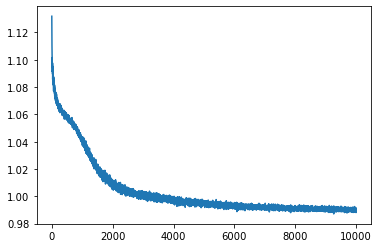

In [43]:
plt.plot(x_axis, loss_history1)

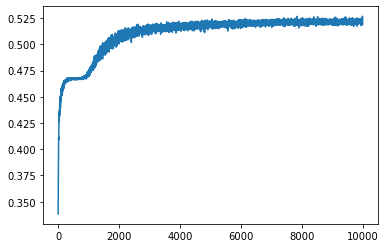

In [44]:
plt.plot(x_axis, accuracy_history1)

In [45]:
## save loss and accuracy

loss_history_df=pd.DataFrame(loss_history)
loss_history_df.to_csv('D:/database/loss_history.csv')
accuracy_history_df=pd.DataFrame(accuracy_history)
accuracy_history_df.to_csv('D:/database/accuracy_history.csv')

In [46]:
## experiments from now on

In [47]:
y_train_df = pd.DataFrame(y_train)
y_dev_df = pd.DataFrame(y_dev)
y_test_df = pd.DataFrame(y_test)

In [48]:
## experiment 1: train draw vs non-draw predictor and use this to separately predict draws
## relabelling to draw (1) and non-draw (0)

y_train_draw = y_train_df.replace(2,0)
y_train_draw = y_train_draw.to_numpy()
y_dev_draw = y_dev_df.replace(2,0)
y_dev_draw = y_dev_draw.to_numpy()
y_test_draw = y_test_df.replace(2,0)
y_test_draw = y_test_draw.to_numpy()
Y_train_draw=one_hot(y_train_draw,2)
Y_test_draw=one_hot(y_test_draw,2)
Y_dev_draw=one_hot(y_dev_draw,2)

In [49]:
## training on the new label

draw_model, draw_loss_history, draw_accuracy_history = train_model(X_train, Y_train_draw, 0.00001, 0.1, 0.20, 256, 1000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                5120      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)               

37/37 [==============================] - 0s 4ms/step - loss: 0.5755 - accuracy: 0.7437
Epoch 59/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5708 - accuracy: 0.7437
Epoch 60/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.7437
Epoch 61/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5708 - accuracy: 0.7437
Epoch 62/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7437
Epoch 63/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5721 - accuracy: 0.7437
Epoch 64/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5723 - accuracy: 0.7437
Epoch 65/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5712 - accuracy: 0.7437
Epoch 66/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5719 - accuracy: 0.7437
Epoch 67/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.7437
Epoc

37/37 [==============================] - 0s 4ms/step - loss: 0.5717 - accuracy: 0.7437
Epoch 139/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5706 - accuracy: 0.7437
Epoch 140/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5704 - accuracy: 0.7437
Epoch 141/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5709 - accuracy: 0.7437
Epoch 142/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5710 - accuracy: 0.7437
Epoch 143/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5707 - accuracy: 0.7437
Epoch 144/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5704 - accuracy: 0.7437
Epoch 145/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.7437
Epoch 146/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5707 - accuracy: 0.7437
Epoch 147/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5711 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5700 - accuracy: 0.7437
Epoch 219/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.7437
Epoch 220/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5706 - accuracy: 0.7437
Epoch 221/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5700 - accuracy: 0.7437
Epoch 222/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5700 - accuracy: 0.7437
Epoch 223/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5719 - accuracy: 0.7437
Epoch 224/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.7437
Epoch 225/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5693 - accuracy: 0.7437
Epoch 226/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5694 - accuracy: 0.7437
Epoch 227/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5711 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5707 - accuracy: 0.7437
Epoch 299/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.7437
Epoch 300/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.7437
Epoch 301/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.7437
Epoch 302/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.7437
Epoch 303/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.7437
Epoch 304/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5706 - accuracy: 0.7437
Epoch 305/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5687 - accuracy: 0.7437
Epoch 306/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.7437
Epoch 307/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5693 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5687 - accuracy: 0.7437
Epoch 379/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5683 - accuracy: 0.7437
Epoch 380/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7437
Epoch 381/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7437
Epoch 382/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5700 - accuracy: 0.7437
Epoch 383/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7437
Epoch 384/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5674 - accuracy: 0.7437
Epoch 385/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5695 - accuracy: 0.7437
Epoch 386/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5693 - accuracy: 0.7437
Epoch 387/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.

37/37 [==============================] - 0s 5ms/step - loss: 0.5686 - accuracy: 0.7437
Epoch 459/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5674 - accuracy: 0.7437
Epoch 460/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.7437
Epoch 461/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5686 - accuracy: 0.7437
Epoch 462/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.7437
Epoch 463/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5686 - accuracy: 0.7437
Epoch 464/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5675 - accuracy: 0.7437
Epoch 465/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5685 - accuracy: 0.7437
Epoch 466/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7437
Epoch 467/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5682 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5684 - accuracy: 0.7437
Epoch 539/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5677 - accuracy: 0.7437
Epoch 540/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5679 - accuracy: 0.7437
Epoch 541/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5679 - accuracy: 0.7437
Epoch 542/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5685 - accuracy: 0.7437
Epoch 543/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5683 - accuracy: 0.7437
Epoch 544/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5663 - accuracy: 0.7437
Epoch 545/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.7437
Epoch 546/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5675 - accuracy: 0.7437
Epoch 547/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5689 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5666 - accuracy: 0.7437
Epoch 619/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5668 - accuracy: 0.7437
Epoch 620/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5678 - accuracy: 0.7437
Epoch 621/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5676 - accuracy: 0.7437
Epoch 622/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5675 - accuracy: 0.7437
Epoch 623/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.7437
Epoch 624/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.7437
Epoch 625/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5671 - accuracy: 0.7437
Epoch 626/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5669 - accuracy: 0.7437
Epoch 627/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5669 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.7437
Epoch 699/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5676 - accuracy: 0.7437
Epoch 700/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.7437
Epoch 701/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5668 - accuracy: 0.7437
Epoch 702/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5655 - accuracy: 0.7437
Epoch 703/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7437
Epoch 704/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5669 - accuracy: 0.7437
Epoch 705/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5659 - accuracy: 0.7437
Epoch 706/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.7437
Epoch 707/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5671 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.7437
Epoch 779/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7437
Epoch 780/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.7437
Epoch 781/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.7437
Epoch 782/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7437
Epoch 783/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5657 - accuracy: 0.7437
Epoch 784/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5659 - accuracy: 0.7437
Epoch 785/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5654 - accuracy: 0.7437
Epoch 786/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5654 - accuracy: 0.7437
Epoch 787/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5657 - accuracy: 0.7437
Epoch 859/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5648 - accuracy: 0.7437
Epoch 860/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5650 - accuracy: 0.7437
Epoch 861/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5659 - accuracy: 0.7437
Epoch 862/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5653 - accuracy: 0.7437
Epoch 863/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.7437
Epoch 864/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5663 - accuracy: 0.7437
Epoch 865/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5647 - accuracy: 0.7437
Epoch 866/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5662 - accuracy: 0.7437
Epoch 867/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5653 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5657 - accuracy: 0.7437
Epoch 939/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.7437
Epoch 940/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.7437
Epoch 941/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5648 - accuracy: 0.7437
Epoch 942/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.7437
Epoch 943/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5660 - accuracy: 0.7437
Epoch 944/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5643 - accuracy: 0.7437
Epoch 945/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5646 - accuracy: 0.7437
Epoch 946/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5652 - accuracy: 0.7437
Epoch 947/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5635 - accuracy: 0.

In [50]:
x_axis = np.arange(1,1001)
draw_loss_history=pd.DataFrame(draw_loss_history)
draw_loss_history=draw_loss_history.to_numpy()
draw_accuracy_history=pd.DataFrame(draw_accuracy_history)
draw_accuracy_history=draw_accuracy_history.to_numpy()
draw_loss_history1 = draw_loss_history.reshape(1000,1)
draw_accuracy_history1 = draw_accuracy_history.reshape(1000,1)

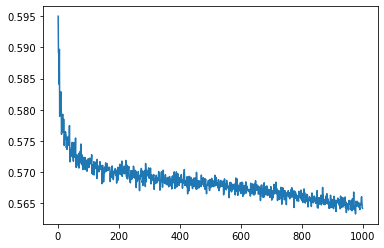

In [51]:
plt.plot(x_axis, draw_loss_history1)

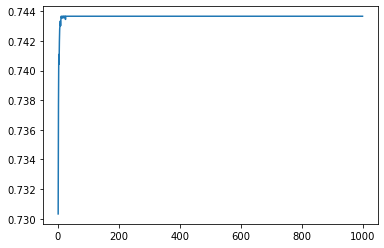

In [52]:
plt.plot(x_axis, draw_accuracy_history1)

In [53]:
## change the predicted labels to draws when this draw model predicts draws 
pred_dev1 = np.zeros((len(pred_dev),1))
draw_pred_dev = np.argmax(test_model(draw_model,X_dev),axis=1)
for i in range(len(pred_dev)):
    if draw_pred_dev[i]==1:
        pred_dev1[i]=1
    else:
        pred_dev1[i]=pred_dev[i]

53/53 [==============================] - 0s 1ms/step


In [54]:
acc_dev = accuracy(y_dev, pred_dev1.T)
print('The accuracy for the dev set is: ' + str(acc_dev))

The accuracy for the dev set is: 0.5319526627218935


In [55]:
pred_test1 = np.zeros((len(pred_test),1))
draw_pred_test = np.argmax(test_model(draw_model,X_test),axis=1)
for i in range(len(pred_test)):
    if draw_pred_test[i]==1:
        pred_test1[i]=1        
    else:
        pred_test1[i]=pred_test[i]

52/52 [==============================] - 0s 1ms/step


In [56]:
acc_test = accuracy(y_test, pred_test1.T)
print('The accuracy for the test set is: ' + str(acc_test))

The accuracy for the test set is: 0.5045759609517999


In [57]:
## experiment 2: train loss vs non-loss predictor and win vs non-win predictor and use these to separately predict draws
## relabelling to loss (0) and non-loss (1)

y_train_loss = y_train_df.replace(2,1)
y_train_loss = y_train_loss.to_numpy()
y_dev_loss = y_dev_df.replace(2,1)
y_dev_loss = y_dev_loss.to_numpy()
y_test_loss = y_test_df.replace(2,1)
y_test_loss = y_test_loss.to_numpy()
Y_train_loss=one_hot(y_train_loss,2)
Y_test_loss=one_hot(y_test_loss,2)
Y_dev_loss=one_hot(y_dev_loss,2)

In [58]:
## training on the new label

loss_model, loss_loss_history, loss_accuracy_history = train_model(X_train, Y_train_loss, 0.00001, 0.1, 0.20, 256, 1000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                5120      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)               

37/37 [==============================] - 0s 5ms/step - loss: 0.5749 - accuracy: 0.7237
Epoch 59/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5754 - accuracy: 0.7237
Epoch 60/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.7237
Epoch 61/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5755 - accuracy: 0.7237
Epoch 62/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5757 - accuracy: 0.7237
Epoch 63/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5751 - accuracy: 0.7237
Epoch 64/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.7237
Epoch 65/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.7237
Epoch 66/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5722 - accuracy: 0.7237
Epoch 67/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5722 - accuracy: 0.7237
Epoc

37/37 [==============================] - 0s 4ms/step - loss: 0.5543 - accuracy: 0.7279
Epoch 139/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5526 - accuracy: 0.7325
Epoch 140/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5524 - accuracy: 0.7299
Epoch 141/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5536 - accuracy: 0.7310
Epoch 142/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5520 - accuracy: 0.7307
Epoch 143/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5518 - accuracy: 0.7308
Epoch 144/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5521 - accuracy: 0.7294
Epoch 145/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5524 - accuracy: 0.7313
Epoch 146/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.7326
Epoch 147/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5508 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5480 - accuracy: 0.7342
Epoch 219/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5492 - accuracy: 0.7355
Epoch 220/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5479 - accuracy: 0.7332
Epoch 221/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5480 - accuracy: 0.7345
Epoch 222/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5469 - accuracy: 0.7354
Epoch 223/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7390
Epoch 224/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5468 - accuracy: 0.7368
Epoch 225/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5464 - accuracy: 0.7353
Epoch 226/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5469 - accuracy: 0.7363
Epoch 227/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.7367
Epoch 299/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7383
Epoch 300/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5448 - accuracy: 0.7394
Epoch 301/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5445 - accuracy: 0.7383
Epoch 302/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5442 - accuracy: 0.7382
Epoch 303/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.7362
Epoch 304/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5429 - accuracy: 0.7375
Epoch 305/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7375
Epoch 306/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.7370
Epoch 307/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5430 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5439 - accuracy: 0.7374
Epoch 379/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7409
Epoch 380/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.7388
Epoch 381/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5437 - accuracy: 0.7389
Epoch 382/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5439 - accuracy: 0.7379
Epoch 383/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5417 - accuracy: 0.7401
Epoch 384/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.7413
Epoch 385/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5438 - accuracy: 0.7383
Epoch 386/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5439 - accuracy: 0.7380
Epoch 387/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5425 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5401 - accuracy: 0.7402
Epoch 459/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7370
Epoch 460/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5409 - accuracy: 0.7366
Epoch 461/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7372
Epoch 462/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.7386
Epoch 463/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.7417
Epoch 464/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5425 - accuracy: 0.7380
Epoch 465/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5420 - accuracy: 0.7399
Epoch 466/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5429 - accuracy: 0.7399
Epoch 467/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5407 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.7395
Epoch 539/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.7386
Epoch 540/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5424 - accuracy: 0.7371
Epoch 541/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5408 - accuracy: 0.7389
Epoch 542/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5416 - accuracy: 0.7383
Epoch 543/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5427 - accuracy: 0.7380
Epoch 544/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.7368
Epoch 545/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.7397
Epoch 546/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5410 - accuracy: 0.7396
Epoch 547/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7400
Epoch 619/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5394 - accuracy: 0.7400
Epoch 620/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5400 - accuracy: 0.7380
Epoch 621/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5396 - accuracy: 0.7398
Epoch 622/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7420
Epoch 623/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5411 - accuracy: 0.7388
Epoch 624/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7384
Epoch 625/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.7400
Epoch 626/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7405
Epoch 627/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5398 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5383 - accuracy: 0.7410
Epoch 699/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7415
Epoch 700/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7369
Epoch 701/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7419
Epoch 702/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5407 - accuracy: 0.7403
Epoch 703/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5392 - accuracy: 0.7400
Epoch 704/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5404 - accuracy: 0.7424
Epoch 705/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.7393
Epoch 706/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7437
Epoch 707/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5383 - accuracy: 0.

37/37 [==============================] - 0s 5ms/step - loss: 0.5397 - accuracy: 0.7384
Epoch 779/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5403 - accuracy: 0.7390
Epoch 780/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5384 - accuracy: 0.7404
Epoch 781/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5386 - accuracy: 0.7408
Epoch 782/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7412
Epoch 783/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5391 - accuracy: 0.7395
Epoch 784/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7398
Epoch 785/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5386 - accuracy: 0.7408
Epoch 786/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7379
Epoch 787/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5387 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5381 - accuracy: 0.7406
Epoch 859/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5367 - accuracy: 0.7408
Epoch 860/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7409
Epoch 861/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5394 - accuracy: 0.7402
Epoch 862/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7396
Epoch 863/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7380
Epoch 864/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5381 - accuracy: 0.7431
Epoch 865/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5385 - accuracy: 0.7398
Epoch 866/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5380 - accuracy: 0.7381
Epoch 867/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5380 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5365 - accuracy: 0.7396
Epoch 939/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5376 - accuracy: 0.7413
Epoch 940/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5383 - accuracy: 0.7425
Epoch 941/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5374 - accuracy: 0.7413
Epoch 942/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5386 - accuracy: 0.7412
Epoch 943/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5364 - accuracy: 0.7412
Epoch 944/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5395 - accuracy: 0.7412
Epoch 945/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5378 - accuracy: 0.7417
Epoch 946/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5374 - accuracy: 0.7408
Epoch 947/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5382 - accuracy: 0.

In [59]:
x_axis = np.arange(1,1001)
loss_loss_history=pd.DataFrame(loss_loss_history)
loss_loss_history=loss_loss_history.to_numpy()
loss_accuracy_history=pd.DataFrame(loss_accuracy_history)
loss_accuracy_history=loss_accuracy_history.to_numpy()
loss_loss_history1 = loss_loss_history.reshape(1000,1)
loss_accuracy_history1 = loss_accuracy_history.reshape(1000,1)

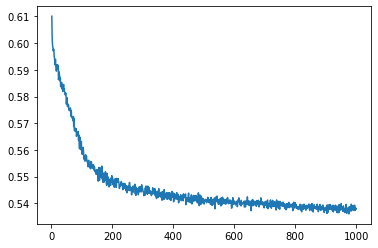

In [60]:
plt.plot(x_axis, loss_loss_history1)

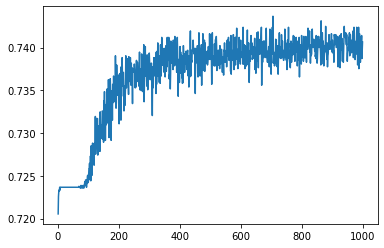

In [61]:
plt.plot(x_axis, loss_accuracy_history1)

In [62]:
## relabelling to non-win (0) and win (1)

y_train_win = y_train_df.replace(1,0)
y_train_win = y_train_df.replace(2,1)
y_train_win = y_train_win.to_numpy()
y_dev_win = y_dev_df.replace(1,0)
y_dev_win = y_dev_df.replace(2,1)
y_dev_win = y_dev_win.to_numpy()
y_test_win = y_test_df.replace(1,0)
y_test_win = y_test_df.replace(2,1)
y_test_win = y_test_win.to_numpy()
Y_train_win=one_hot(y_train_win,2)
Y_test_win=one_hot(y_test_win,2)
Y_dev_win=one_hot(y_dev_win,2)

In [63]:
## training on the new label

win_model, win_loss_history, win_accuracy_history = train_model(X_train, Y_train_win, 0.00001, 0.1, 0.20, 256, 1000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                5120      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 64)               

37/37 [==============================] - 0s 5ms/step - loss: 0.5890 - accuracy: 0.7237
Epoch 59/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.7237
Epoch 60/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5887 - accuracy: 0.7237
Epoch 61/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5884 - accuracy: 0.7237
Epoch 62/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5862 - accuracy: 0.7237
Epoch 63/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5893 - accuracy: 0.7237
Epoch 64/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5898 - accuracy: 0.7237
Epoch 65/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5883 - accuracy: 0.7237
Epoch 66/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5884 - accuracy: 0.7237
Epoch 67/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.7237
Epoc

37/37 [==============================] - 0s 4ms/step - loss: 0.5630 - accuracy: 0.7240
Epoch 139/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5615 - accuracy: 0.7238
Epoch 140/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5629 - accuracy: 0.7243
Epoch 141/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.7241
Epoch 142/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5620 - accuracy: 0.7238
Epoch 143/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5632 - accuracy: 0.7235
Epoch 144/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5614 - accuracy: 0.7245
Epoch 145/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5581 - accuracy: 0.7241
Epoch 146/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5627 - accuracy: 0.7239
Epoch 147/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5610 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5498 - accuracy: 0.7352
Epoch 219/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5487 - accuracy: 0.7351
Epoch 220/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5518 - accuracy: 0.7325
Epoch 221/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5491 - accuracy: 0.7338
Epoch 222/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5501 - accuracy: 0.7351
Epoch 223/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5486 - accuracy: 0.7357
Epoch 224/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5468 - accuracy: 0.7372
Epoch 225/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5500 - accuracy: 0.7341
Epoch 226/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5483 - accuracy: 0.7375
Epoch 227/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5492 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5442 - accuracy: 0.7377
Epoch 299/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5476 - accuracy: 0.7347
Epoch 300/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5452 - accuracy: 0.7375
Epoch 301/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5456 - accuracy: 0.7350
Epoch 302/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.7354
Epoch 303/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5451 - accuracy: 0.7351
Epoch 304/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5465 - accuracy: 0.7411
Epoch 305/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5453 - accuracy: 0.7395
Epoch 306/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5452 - accuracy: 0.7377
Epoch 307/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5462 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5434 - accuracy: 0.7393
Epoch 379/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5444 - accuracy: 0.7388
Epoch 380/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.7386
Epoch 381/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.7379
Epoch 382/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.7394
Epoch 383/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5438 - accuracy: 0.7393
Epoch 384/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5431 - accuracy: 0.7395
Epoch 385/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5445 - accuracy: 0.7371
Epoch 386/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5424 - accuracy: 0.7406
Epoch 387/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.7416
Epoch 459/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5406 - accuracy: 0.7406
Epoch 460/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5423 - accuracy: 0.7406
Epoch 461/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.7408
Epoch 462/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5409 - accuracy: 0.7393
Epoch 463/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.7398
Epoch 464/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5440 - accuracy: 0.7408
Epoch 465/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7370
Epoch 466/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.7409
Epoch 467/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5422 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5412 - accuracy: 0.7393
Epoch 539/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5420 - accuracy: 0.7399
Epoch 540/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5413 - accuracy: 0.7397
Epoch 541/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5417 - accuracy: 0.7408
Epoch 542/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5410 - accuracy: 0.7399
Epoch 543/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5417 - accuracy: 0.7398
Epoch 544/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.7385
Epoch 545/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5426 - accuracy: 0.7382
Epoch 546/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.7420
Epoch 547/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5411 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5401 - accuracy: 0.7396
Epoch 619/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5395 - accuracy: 0.7410
Epoch 620/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.7401
Epoch 621/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.7395
Epoch 622/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5392 - accuracy: 0.7417
Epoch 623/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5427 - accuracy: 0.7401
Epoch 624/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7400
Epoch 625/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5416 - accuracy: 0.7393
Epoch 626/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5391 - accuracy: 0.7390
Epoch 627/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7416
Epoch 699/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7401
Epoch 700/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7374
Epoch 701/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5400 - accuracy: 0.7429
Epoch 702/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.7400
Epoch 703/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7396
Epoch 704/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.7393
Epoch 705/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5393 - accuracy: 0.7388
Epoch 706/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5394 - accuracy: 0.7385
Epoch 707/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5394 - accuracy: 0.7415
Epoch 779/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5392 - accuracy: 0.7426
Epoch 780/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7401
Epoch 781/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5392 - accuracy: 0.7400
Epoch 782/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5401 - accuracy: 0.7418
Epoch 783/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5385 - accuracy: 0.7412
Epoch 784/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7418
Epoch 785/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7414
Epoch 786/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.7401
Epoch 787/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5387 - accuracy: 0.7410
Epoch 859/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7411
Epoch 860/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5408 - accuracy: 0.7397
Epoch 861/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5404 - accuracy: 0.7394
Epoch 862/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5385 - accuracy: 0.7422
Epoch 863/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5395 - accuracy: 0.7403
Epoch 864/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.7403
Epoch 865/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5383 - accuracy: 0.7387
Epoch 866/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5386 - accuracy: 0.7397
Epoch 867/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5387 - accuracy: 0.

37/37 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7411
Epoch 939/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7397
Epoch 940/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.7384
Epoch 941/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7396
Epoch 942/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5394 - accuracy: 0.7383
Epoch 943/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5382 - accuracy: 0.7400
Epoch 944/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.5372 - accuracy: 0.7396
Epoch 945/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5369 - accuracy: 0.7415
Epoch 946/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5378 - accuracy: 0.7411
Epoch 947/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.5382 - accuracy: 0.

In [64]:
x_axis = np.arange(1,1001)
win_loss_history=pd.DataFrame(win_loss_history)
win_loss_history=win_loss_history.to_numpy()
win_accuracy_history=pd.DataFrame(win_accuracy_history)
win_accuracy_history=win_accuracy_history.to_numpy()
win_loss_history1 = win_loss_history.reshape(1000,1)
win_accuracy_history1 = win_accuracy_history.reshape(1000,1)

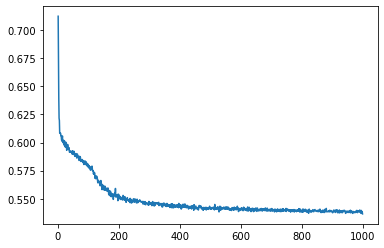

In [65]:
plt.plot(x_axis, win_loss_history1)

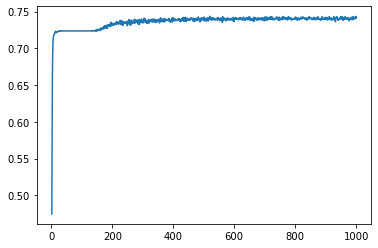

In [66]:
plt.plot(x_axis, win_accuracy_history1)

In [67]:
## change the predicted labels to draws when the loss model predicts a non-loss and the win model predicts a non-win 

pred_dev2 = np.zeros((len(pred_dev),1))
loss_pred_dev = np.argmax(test_model(loss_model,X_dev),axis=1)
win_pred_dev = np.argmax(test_model(win_model,X_dev),axis=1)
for i in range(len(pred_dev)):
    if loss_pred_dev[i]==1 and win_pred_dev[i]==0:
        pred_dev2[i]=1
    else:
        pred_dev2[i]=pred_dev[i]

53/53 [==============================] - 0s 1ms/step


In [68]:
acc_dev = accuracy(y_dev, pred_dev2.T)
print('The accuracy for the dev set is: ' + str(acc_dev))

The accuracy for the dev set is: 0.5319526627218935


In [69]:
pred_test2 = np.zeros((len(pred_test),1))
loss_pred_test = np.argmax(test_model(loss_model,X_test),axis=1)
win_pred_test = np.argmax(test_model(win_model,X_test),axis=1)
for i in range(len(pred_test)):
    if loss_pred_dev[i]==1 and win_pred_dev[i]==0:
        pred_test2[i]=1
    else:
        pred_test2[i]=pred_test[i]

52/52 [==============================] - 0s 2ms/step


In [70]:
acc_test = accuracy(y_test, pred_test2.T)
print('The accuracy for the dev set is: ' + str(acc_test))

The accuracy for the dev set is: 0.5033557046979866


In [72]:
confusion = pd.DataFrame(pred_test)
confusion.to_csv('D:/confusion.csv')